# Оглавление

- [Вступление](#intro)
- [Подготовка данных](#preparing)
  - [Выводы по подготовке](#preparing_conclusion)
- [Обучение и проверка моделей](#fit)
  - [Регион 1](#fit_1)
  - [Регион 2](#fit_2)
  - [Регион 3](#fit_3)
  - [Выводы по моделям](#fit_conclusion)
- [Подготовка к расчёту прибыли](#prep_profit_calc)
- [Расчёт прибыли и рисков](#profit_calc)
  - [Регион 1](#profit_1)
  - [Регион 2](#profit_2)
  - [Регион 3](#profit_3)
- [Выводы](#conclusion)

<a id='intro'></a>
## Вступление
Перед нами стоит задача выбрать место для бурения новых нефтескважин. Нам предоставлены данные по трём регионам в которых содержаться объёмы и качество нефти, по каждому региону свой отдельный файл. Изучим предоставленные данные, при необходимости сделаем предобработку. Будем использовать эти данные чтобы построить модель машинного обучения которая поможет нам определить потенциально наиболее прибыльный регион. После этого техникой Bootstrap проанализируем прибыль и возможные риски.

<a id='preparing'></a>
## Загрузка и подготовка данных

**Импортируем необходимые библиотеки**

In [1]:
import pandas as pd
import numpy as np

from scipy import stats as st

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

**Читаем исходные файлы**

In [2]:
region_1_data = pd.read_csv('geo_data_0.csv')
region_2_data = pd.read_csv('geo_data_1.csv')
region_3_data = pd.read_csv('geo_data_2.csv')

**Основная информация о датафрейме**

In [3]:
region_1_data.info()
region_2_data.info()
region_3_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

In [4]:
display(region_1_data.head())
display(region_2_data.head())
display(region_3_data.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


По каждому региону имеем одинаковое количество строк (месторождений) - 100000. Целевой признак находится в колонке `product` - объём запасов нефти. Колонки `f0`, `f1`, `f2` содержат признаки по которым нам нужно будет делать предсказания с помощью модели. Колонка `id` содержит идентификатор скважины, для обучения модели эти данные не будут нужны, удалим их, но сначала посмотрим есть ли в данных пропуски.

**Пропуски**

In [5]:
display(region_1_data.isna().sum())
display(region_2_data.isna().sum())
display(region_3_data.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

В данных пропусков нет. 

**Целевой признак**

Посмотрим на распределение целевого признака в регионах.

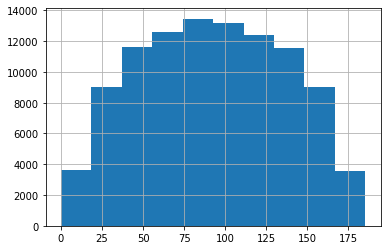

In [6]:
region_1_data['product'].hist();

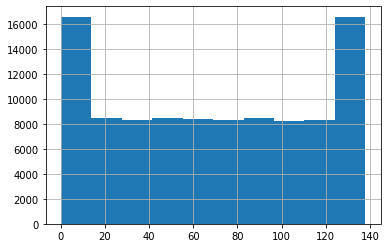

In [7]:
region_2_data['product'].hist();

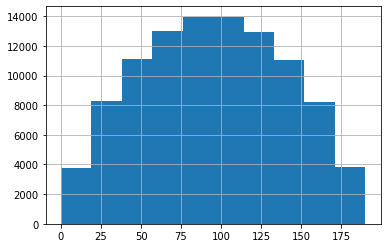

In [8]:
region_3_data['product'].hist();

Распределения 1 и 3 регионов похоже. Оба имеют нормальное или похожее на нормальное распределение. У 2 региона есть сильные пики в крайних точках, в остальных диапазонах распределение равномерное.

**Удаление ненужных данных**

Удалим колонку `id` из всех трёх датафреймов.

In [9]:
region_1_data = region_1_data.drop(['id'], axis=1).reset_index(drop=True)
region_2_data = region_2_data.drop(['id'], axis=1).reset_index(drop=True)
region_3_data = region_3_data.drop(['id'], axis=1).reset_index(drop=True)

In [10]:
display(region_1_data.info())
display(region_2_data.info())
display(region_3_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


None

Ненужную колонку удалили, можем приступать к разбивке на выборки.

**Выделение целевого признака**

Целевой признак находится в колонке `product`, остальные будем использовать в качестве признаков. Выделим целевой признак в отдельную переменную для каждого региона и признаки так же в отдельные переменные.

In [11]:
features_1 = region_1_data.drop('product', axis=1)
features_2 = region_2_data.drop('product', axis=1)
features_3 = region_3_data.drop('product', axis=1)

target_1 = region_1_data['product']
target_2 = region_2_data['product']
target_3 = region_3_data['product']

**Полиномиальные признаки**

Сгенерируем полиномиальные признаки которые помогут нам для обучения модели.

In [12]:
poly = PolynomialFeatures(degree=6, include_bias=False)
poly_features_1 = poly.fit_transform(features_1)
poly_features_2 = poly.fit_transform(features_2)
poly_features_3 = poly.fit_transform(features_3)

**Разбитие данных на выборки**

Теперь нам нужно получить две выборки:

- Тренировочную - для обучения модели
- Валидационную - на которой мы будем проверять модель

Разделение произведём в соотношении 3:1, тоесть 75% - тренировочная выборка, 25% - валидационная выборка.

In [13]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    poly_features_1, target_1, test_size=0.25, random_state=12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    poly_features_2, target_2, test_size=0.25, random_state=12345)

features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    poly_features_3, target_3, test_size=0.25, random_state=12345)

In [14]:
print(features_train_1.shape)
print(features_valid_1.shape)
print(target_train_1.shape)
print(target_valid_1.shape)

(75000, 83)
(25000, 83)
(75000,)
(25000,)


In [15]:
print(features_train_2.shape)
print(features_valid_2.shape)
print(target_train_2.shape)
print(target_valid_2.shape)

(75000, 83)
(25000, 83)
(75000,)
(25000,)


In [16]:
print(features_train_3.shape)
print(features_valid_3.shape)
print(target_train_3.shape)
print(target_valid_3.shape)

(75000, 83)
(25000, 83)
(75000,)
(25000,)


Сделали разбитие, проверили размеры - всё корректно.

<a id='preparing_conclusion'></a>
### Выводы по подготовке данных

Изучили данные.

- Пропусков в данных нет.
- Посмотрели на распеделение целевого признака по регионам. Во 2 регионе распределение сильно отличается от 1 и 3.
- Удалили ненужную для построения модели колонку `id`.
- Выделили целевой признак в отдельную переменную.
- Сделали разбитие данных на тренировочную и валидационную выборки в соотношении 3:1 (75%/25%)

<a id='fit'></a>
## Обучение и проверка модели

Будем использовать линейную регрессию в качестве модели. Обучим её использую кросс-валидацию GridSearchCV.

<a id='fit_1'></a>
### Регион 1

In [17]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {}
model_1 = LinearRegression()

model_1_cv = GridSearchCV(estimator = model_1, 
                          param_grid = params, 
                          scoring= 'r2', 
                          cv = folds, 
                          verbose = 1,
                          return_train_score=True)
model_1_cv.fit(features_train_1, target_train_1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=LinearRegression(), param_grid={},
             return_train_score=True, scoring='r2', verbose=1)

In [18]:
predicted_valid_1 = model_1_cv.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predicted_valid_1, squared=False)


print("Регион 1")
print("RMSE =", rmse_1)
print("R2:", model_1_cv.best_score_)
print("Среднее количество сырья =", predicted_valid_1.mean())

Регион 1
RMSE = 37.033929119113814
R2: 0.2961016010654381
Среднее количество сырья = 92.54062437295887


В первом регионе модель предсказала содержание среднего колличества сырья 92.54тыс. баррелей. **RMSE** модели = **37.03**. Посмотрим теперь модель для второго региона.

<a id='fit_2'></a>
### Регион 2

In [19]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {}
model_2 = LinearRegression()

model_2_cv = GridSearchCV(estimator = model_2, 
                          param_grid = params, 
                          scoring= 'r2', 
                          cv = folds, 
                          verbose = 1,
                          return_train_score=True)
model_2_cv.fit(features_train_2, target_train_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=LinearRegression(), param_grid={},
             return_train_score=True, scoring='r2', verbose=1)

In [20]:
predicted_valid_2 = model_2_cv.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predicted_valid_2, squared=False)


print("Регион 2")
print("RMSE =", rmse_2)
print("R2:", model_2_cv.best_score_)
print("Среднее количество сырья =", predicted_valid_2.mean())

Регион 2
RMSE = 0.7523874998163472
R2: 0.9997349362392669
Среднее количество сырья = 68.72966228921456


Во втором регионе модель предсказала содержание среднего колличества сырья 68.73тыс. баррелей. **RMSE** модели = **0.75**. Посмотрим теперь модель для третьего региона.

<a id='fit_3'></a>
### Регион 3

In [21]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {}
model_3 = LinearRegression()

model_3_cv = GridSearchCV(estimator = model_3, 
                          param_grid = params, 
                          scoring= 'r2', 
                          cv = folds, 
                          verbose = 1,
                          return_train_score=True)
model_3_cv.fit(features_train_3, target_train_3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=LinearRegression(), param_grid={},
             return_train_score=True, scoring='r2', verbose=1)

In [22]:
predicted_valid_3 = model_3_cv.predict(features_valid_3)
rmse_3 = mean_squared_error(target_valid_3, predicted_valid_3, squared=False)


print("Регион 3")
print("RMSE =", rmse_3)
print("R2:", model_3_cv.best_score_)
print("Среднее количество сырья =", predicted_valid_3.mean())

Регион 3
RMSE = 37.989303738314234
R2: 0.2745880174385956
Среднее количество сырья = 95.01581689377421


В третьем регионе модель предсказала содержание среднего колличества сырья 95.02тыс. баррелей. **RMSE** модели = **37.99**.

<a id='fit_conclusion'></a>
### Выводы по моделям
Построили модели для каждого региона предсказывающие количество сырья у месторождения. Лучшую точность модель показывает во втором регионе, но в нём среднее количество сырья меньше чем двух других.

<a id='prep_profit_calc'></a>
## Подготовка к расчёту прибыли

Запишим в переменные нужные нам в дальнейшем значения для рассчётов.

In [23]:
budget = 10**10 # Бюджет на разработку скважин. 10 в 10 степени = 10млрд. рублей
income = 450 * 10**3 # Доход с каждой единицы продукта (тыс. баррелей). 450тыс. рублей

n_bootstraps = 1000 # Количество выборок для bootstrap
n_marks = 500 # Количество точек для образца в bootstrap
n_target = 200 # Количество точек с наилучшими значениями
c_interval = 0.95 # Доверительный интервал

predicted_1 = pd.Series(predicted_valid_1).reset_index(drop=True) # Предсказания модели по каждому региону
predicted_2 = pd.Series(predicted_valid_2).reset_index(drop=True)
predicted_3 = pd.Series(predicted_valid_3).reset_index(drop=True)

target_valid_1 = target_valid_1.reset_index(drop=True) # Правильные ответы по кажодому региону на валидационной выборке 
target_valid_2 = target_valid_2.reset_index(drop=True)
target_valid_3 = target_valid_3.reset_index(drop=True)

В условии прописано что выбрать надо 200 лучших месторождений в регионе. Рассчитаем минимальный объём сырья 200 месторождения необходимый для покрытия бюджета выделенного на разработку скважин.

In [24]:
avg_min =  budget / 200 / income
print(avg_min)

111.11111111111111


Выяснили про при разработке 200 месторождений, средний объём их должен привышать примерно 112тыс. баррелей. Среднее количество сырья в целом по регионам меньше этого значения.

<a id='profit_calc'></a>
## Расчёт прибыли и рисков 

Напишем функцию для рассчёта прибыли.

In [35]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return income * selected.sum() - budget

Используя bootstrap с 1000 выборок узнаем распределение прибыли. Будем брать образцы по 500 точек и выбирать их них 200 точек с наибольшими значениями. Узнаем среднюю прибыль, 95% доверительный интервал и посчитаем риск убытков. При выборе региона оставим только те у которых риск убытков меньше 2.5%.

<a id='profit_1'></a>
### Регион 1

In [37]:
state = np.random.RandomState(12345)
    
values = []
for i in range(1000):
    target_subsample = target_valid_1.sample(n=n_marks, replace=True, random_state=state) 
    probs_subsample = predicted_1[target_subsample.index]
    values.append(revenue(target_subsample, probs_subsample, n_target))

values = pd.Series(values)
mean = values.mean()
confidence_interval = st.t.interval(c_interval, len(values)-1, loc=mean, scale=values.sem())
negative_values = values[values < 0]
loss = len(negative_values) / len(values)


print("Средняя прибыль: {0:.3f} (миллионов)".format(mean / 10**6))
print("{0:.0%}-ый доверительный интервал: {1}".format(c_interval, confidence_interval))
print("Риск убытков: {0:.1%}".format(loss))

Средняя прибыль: 525.595 (миллионов)
95%-ый доверительный интервал: (509053824.4801459, 542136598.7822032)
Риск убытков: 2.0%


В первом регионе риск убытков 2% и средняя прибыль 525,6м рублей. Данные риски нас устраивают, посмотрим на остальные регионы.

<a id='profit_2'></a>
### Регион 2

In [27]:
state = np.random.RandomState(12345)
    
values = []
for i in range(n_bootstraps):
    target_subsample = target_valid_2.sample(n=n_marks, replace=True, random_state=state) 
    probs_subsample = predicted_2[target_subsample.index]
    values.append(revenue(target_subsample, probs_subsample, n_target))

values = pd.Series(values)
mean = values.mean()
confidence_interval = st.t.interval(c_interval, len(values)-1, loc=mean, scale=values.sem())
negative_values = values[values < 0]
loss = len(negative_values) / len(values)


print("Средняя прибыль: {0:.3f} (миллионов)".format(mean / 10**6))
print("{0:.0%}-ый доверительный интервал: {1}".format(c_interval, confidence_interval))
print("Риск убытков: {0:.1%}".format(loss))

Средняя прибыль: 515.233 (миллионов)
95%-ый доверительный интервал: (501633882.79517, 528831692.437684)
Риск убытков: 1.0%


Получили риск убытков: 1%, средняя прибыль: 515,2 миллионов рублей. рублей. Риск убытков меньше чем в первом регионе, но и прибыль меньше, так как 2% нас устраивает остановимся на данный момент на первом регионе. Осталось посмотреть на третий регион.

<a id='profit_3'></a>
### Регион 3

In [47]:
state = np.random.RandomState(12345)
    
values = []
for i in range(n_bootstraps):
    target_subsample = target_valid_3.sample(n=n_marks, replace=True, random_state=state) 
    probs_subsample = predicted_3[target_subsample.index]
    values.append(revenue(target_subsample, probs_subsample, n_target))

values = pd.Series(values)
mean = values.mean()
confidence_interval = st.t.interval(c_interval, len(values)-1, loc=mean, scale=values.sem())
negative_values = values[values < 0]
loss = len(negative_values) / len(values)


print("Средняя прибыль: {0:.3f} (миллионов)".format(mean / 10**6))
print("{0:.0%}-ый доверительный интервал: {1}".format(c_interval, confidence_interval))
print("Риск убытков: {0:.1%}".format(loss))

Средняя прибыль: 709.164 (миллионов)
95%-ый доверительный интервал: (691705284.6932027, 726622205.0023091)
Риск убытков: 0.4%


Риск убытков: 0.4% и средняя прибыль: 709,2м рублей. По обоим показателям этот регион является лучшим.

<a id='conclusion'></a>
## Выводы

Перед нами стояла задача выбора региона для разработки новых нефтескважин. Нам были предоставлены данные по трем регионам из которых нужно выбрать лучший. Исследовали эти данные, удалили ненужные данные, добавили полиномиальные признаки. Разбили данные в каждом регионе на две выборки необходимые для обучения и тестирования модели.

Перед моделью стояла задача регрессии. Использовали линейную регрессию в качестве модели, обучали её с помощь кросс-валидации GridSearchCV. Сделали предсказания на валидационной выборке по каждому региону.

Подготовили необходимые данные для расчёта прибыли, а так же написали функцию для её расчёта. В условии имеем:

- Бюджет: 10милиардов рублей
- Доход: 450т рублей с каждой единицы сырья
- Выбрать 200 для для разработки в регионе
- Риск убытков должен быть ниже 2.5%

Используя данную информацию рассчитали прибыли по регионам. По риску убытков все регионы подходят, но средняя прибыль лучшая в третьем регионе:

- **Средняя прибыль**: 709,2миллиона рублей
- **Доверительный интервал (95%)**: 692-727м рублей
- **Риск убытков**: 0.4%

На основе этих данные можем предложить третий регион для разработки.